In [47]:
import os
import sys
import re
import string
from pyspark.sql import SparkSession
from pyspark.sql.functions import regexp_replace
from pyspark.sql.functions import lower, col

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

In [48]:
def init_spark():
  spark = SparkSession.builder.appName("BigData").getOrCreate()
  sc = spark.sparkContext
  return spark,sc

## Preprocess dataset for training and testing.

In [49]:
def get_sample_from_file(file_name, output_file, sample_size = 10_000):
    content = ""
    with open(file_name, "r") as f:
        for i in range(sample_size):
            content += f.readline()
    with open(output_file, "w") as f:
        f.write(content)

In [52]:
# load data from json file with spark
def load_data_from_json(spark, file_name):
    return spark.read.json(file_name)

### Visualize dataset

In [53]:
sc = init_spark()[0]
arxiv_dataset = load_data_from_json(sc, "arxiv-sample.json")
# view first 5 rows
arxiv_dataset.take(5)

[Row(abstract='  A fully differential calculation in perturbative quantum chromodynamics is\npresented for the production of massive photon pairs at hadron colliders. All\nnext-to-leading order perturbative contributions from quark-antiquark,\ngluon-(anti)quark, and gluon-gluon subprocesses are included, as well as\nall-orders resummation of initial-state gluon radiation valid at\nnext-to-next-to-leading logarithmic accuracy. The region of phase space is\nspecified in which the calculation is most reliable. Good agreement is\ndemonstrated with data from the Fermilab Tevatron, and predictions are made for\nmore detailed tests with CDF and DO data. Predictions are shown for\ndistributions of diphoton pairs produced at the energy of the Large Hadron\nCollider (LHC). Distributions of the diphoton pairs from the decay of a Higgs\nboson are contrasted with those produced from QCD processes at the LHC, showing\nthat enhanced sensitivity to the signal can be obtained with judicious\nselection 

## Clean dataset

### Searcing for missing values

In [136]:
# search for missing values
print("Number of missing values in abstract column: ", arxiv_dataset.filter(arxiv_dataset.abstract.isNull()).count())
print("Number of missing values in title column: ", arxiv_dataset.filter(arxiv_dataset.title.isNull()).count())
print("Number of missing values in categories column: ", arxiv_dataset.filter(arxiv_dataset.categories.isNull()).count())
print("Number of missing values in id column: ", arxiv_dataset.filter(arxiv_dataset.id.isNull()).count())
print("Number of missing values in submitter column: ", arxiv_dataset.filter(arxiv_dataset.submitter.isNull()).count())
print("Number of missing values in authors column: ", arxiv_dataset.filter(arxiv_dataset.authors.isNull()).count())
print("Number of missing values in report-no column: ",arxiv_dataset.filter(arxiv_dataset["report-no"].isNull()).count() )
print("Number of missing values in comments column: ", arxiv_dataset.filter(arxiv_dataset.comments.isNull()).count())
print("Number of missing values in doi column: ", arxiv_dataset.filter(arxiv_dataset.doi.isNull()).count())
print("Number of missing values in journal-ref column: ", arxiv_dataset.filter(arxiv_dataset["journal-ref"].isNull()).count())
print("Number of missing values in versions column: ", arxiv_dataset.filter(arxiv_dataset.versions.isNull()).count())


Number of missing values in abstract column:  0
Number of missing values in title column:  0
Number of missing values in categories column:  0
Number of missing values in id column:  0
Number of missing values in submitter column:  0
Number of missing values in authors column:  0
Number of missing values in report-no column:  9118
Number of missing values in comments column:  1138
Number of missing values in doi column:  3641
Number of missing values in journal-ref column:  4571
Number of missing values in versions column:  0


In [93]:
# show rows with empty fields
arxiv_dataset.filter(arxiv_dataset["abstract"] == "").show()
arxiv_dataset.filter(arxiv_dataset["title"] == "").show()
arxiv_dataset.filter(arxiv_dataset["authors"] == "").show()
arxiv_dataset.filter(arxiv_dataset["categories"] == "").show()

+--------+-------+--------------+----------+--------+---+---+-----------+-------+---------+---------+-----+-----------+--------+
|abstract|authors|authors_parsed|categories|comments|doi| id|journal-ref|license|report-no|submitter|title|update_date|versions|
+--------+-------+--------------+----------+--------+---+---+-----------+-------+---------+---------+-----+-----------+--------+
+--------+-------+--------------+----------+--------+---+---+-----------+-------+---------+---------+-----+-----------+--------+

+--------+-------+--------------+----------+--------+---+---+-----------+-------+---------+---------+-----+-----------+--------+
|abstract|authors|authors_parsed|categories|comments|doi| id|journal-ref|license|report-no|submitter|title|update_date|versions|
+--------+-------+--------------+----------+--------+---+---+-----------+-------+---------+---------+-----+-----------+--------+
+--------+-------+--------------+----------+--------+---+---+-----------+-------+---------+-----

### Basic preprocessing functions

In [145]:
# fill ALL NULL values with empty string : use after removing rows with empty fields
def fill_na_with_empty_string(df):
    return df.fillna("")

# remove rows with empty fields
def remove_empty_fields(df, field_name):
    return df.filter(df[field_name] != "")

# remove "\n" from text
def remove_empty_newlines(df, field_name):
    return df.withColumn(field_name, regexp_replace(col(field_name), "\n", " "))

# remove math formulas and latex
def remove_math_formula(df, field_name):
    return df.withColumn(field_name, regexp_replace(col(field_name), "\$.*?\$", ""))

# convert to lowercase
def convert_to_lowercase(df, field_name):
    return df.withColumn(field_name, lower(col(field_name)))

# remove extra spaces
def remove_extra_spaces(df, field_name):
    df = df.withColumn(field_name, regexp_replace(col(field_name), " +", " "))
    df = df.withColumn(field_name, regexp_replace(col(field_name), "^ +", ""))
    return df

# remove punctuation
def remove_punctuation(df, field_name):
    return df.withColumn(field_name, regexp_replace(col(field_name), "[^\w\s]", ""))


In [119]:
arxiv_dataset.select("abstract").show(5, truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|abstract                 

### Clear 'abstract' column

In [96]:
arxiv_dataset = remove_empty_fields(arxiv_dataset, "abstract")
arxiv_dataset = remove_empty_newlines(arxiv_dataset, "abstract")
# remove math equations from abstract ? 
# maybe we don't need to do this, because we can use the math equations for our model?
arxiv_dataset = remove_math_formula(arxiv_dataset, "abstract")
arxiv_dataset = convert_to_lowercase(arxiv_dataset, "abstract")
arxiv_dataset = remove_extra_spaces(arxiv_dataset, "abstract")

In [97]:
arxiv_dataset.select("abstract").show(5, truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|abstract       

### Lemmatization (will follow)

## Convert Abstract to Vector Representation

In [23]:
from pyspark.ml.feature import Word2Vec
from pyspark.ml.feature import Tokenizer

In [25]:
# create a Word2Vec model
input_col = "abstract"
output_col = "abstract_vector"

words2vec_model = Word2Vec(
    inputCol="words",
    outputCol=output_col,
    vectorSize=100,
    minCount=5
)
tokenized = Tokenizer(inputCol=input_col, outputCol="words")
tokenized_dataset = tokenized.transform(arxiv_dataset)
model = words2vec_model.fit(tokenized_dataset)
# show the vector of the first abstract


In [27]:
model.getVectors().show(truncate=False)

+-------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [22]:
# use tokenizer to split words
from pyspark.ml.feature import Tokenizer
# create a simple example dataframe with a single column called "text"
sc = init_spark()[0]
data = sc.createDataFrame([
    (0, "Hi I heard about Spark"),
    (1, "I wish Java could use case classes"),
    (2, "Logistic,regression,models,are,neat")
], ["id", "text"])


# use tokenizer to split words
tokenizer = Tokenizer(inputCol="text", outputCol="words")
tokenized = tokenizer.transform(data)
# view the transformed column
tokenized.select("words").show(truncate=False)
# view data
# data.show(1)



+------------------------------------------+
|words                                     |
+------------------------------------------+
|[hi, i, heard, about, spark]              |
|[i, wish, java, could, use, case, classes]|
|[logistic,regression,models,are,neat]     |
+------------------------------------------+



### Vizualize most popular categories based on how many authors contributed to that category

In [197]:
# loading back the data
arxiv_dataset = load_data_from_json(sc, "arxiv-sample.json")

In [194]:
def remove_text_between_parentheses(text):
    result = []
    open_bracket_count = 0

    for char in text:
        if char == '(':
            open_bracket_count += 1
        elif char == ')':
            open_bracket_count -= 1
        elif open_bracket_count == 0:
            result.append(char)

    return ''.join(result)

text ="Arthur Jaffe (1) and Gordon Ritter (1) ((1) Harvard University)"
print(remove_text_between_parentheses(text))

Arthur Jaffe  and Gordon Ritter  


In [195]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
remove_text_between_parentheses_udf = udf(remove_text_between_parentheses, StringType())
# apply the function to the authors column
arxiv_dataset = arxiv_dataset.withColumn("authors", remove_text_between_parentheses_udf("authors"))

In [149]:
# preprocess authors column : remove the "and" word and split the authors by comma
def preprocess_authors(df):
    return df.withColumn("authors", regexp_replace(col("authors"), " and ", ", "))

# preprocess authors column : remove extra commas
def remove_authors_extra_commas(df):
    return df.withColumn("authors", regexp_replace(col("authors"), ",+", ","))
    
# preprocess authors column : remove empty spaces (more than one space)
def remove_authors_extra_spaces(df):
    return df.withColumn("authors", regexp_replace(col("authors"), " +", " "))

# preprocess authors column : remove parentheses and their content
def remove_authors_parentheses(df):
    return df.withColumn("authors", regexp_replace(col("authors"), "\(.+?\)", ""))
    

In [150]:
arxiv_dataset = preprocess_authors(arxiv_dataset)
arxiv_dataset = remove_authors_extra_commas(arxiv_dataset)
arxiv_dataset = remove_authors_extra_spaces(arxiv_dataset)

In [198]:
# see the first 5 rows
arxiv_dataset.select("authors").show(50, truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|authors                                                                                                                                                                                                                                  |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|C. Bal\'azs, E. L. Berger, P. M. Nadolsky, C.-P. Yuan                                                                                                                                                                                    |
|Ileana Streinu and Louis Theran                        

In [ ]:
for row in arxiv_dataset.select("categories", "authors").collect():
    print(row.authors)

In [95]:
ignore_authors = ["et al.", "et al"]

In [ ]:
# get all categories
categories = arxiv_dataset.select("categories").collect()
categories = [row.categories for row in categories]
categories = [cat.split(" ") for cat in categories]
categories = [item for sublist in categories for item in sublist]
categories = list(set(categories))
print("Number of categories: ", len(categories))

# # get all authors
authors = arxiv_dataset.select("authors").collect()
authors = [row.authors for row in authors]
authors = [author.split(", ") for author in authors]
authors = [item for sublist in authors for item in sublist]
authors = list(set(authors))
print("Number of authors: ", len(authors))

# get all authors for each category
categories_authors = {}
loading_status = 0
complete_status = len(categories)
for category in categories:
    categories_authors[category] = []
    loading_status += 1
    print("Loading status: ", loading_status, "/", complete_status)
    for row in arxiv_dataset.select("categories", "authors").collect():
        if loading_status % 1000 == 0:
            print("Loading status: ", loading_status)
        if category in row.categories:
            categories_authors[category].append(row.authors.split(", "))

# flatten the list
for category in categories_authors:
     categories_authors[category] = [item for sublist in categories_authors[category] for item in sublist]
# remove duplicates
for category in categories_authors:
    categories_authors[category] = list(set(categories_authors[category]))
# get number of authors for each category
for category in categories_authors:
    categories_authors[category] = len(categories_authors[category])
# sort categories based on number of authors
categories_authors = {k: v for k, v in sorted(categories_authors.items(), key=lambda item: item[1], reverse=True)}
# # get top 10 categories
top_categories = list(categories_authors.keys())[:10]



### Topic extraction and stats (most popular topic per category)

BERTopic? Gensim? LDA?

In [160]:
# loading back the data
arxiv_dataset = load_data_from_json(sc, "arxiv-sample.json")

In [173]:
# https://arxiv.org/help/api/user-manual
category_map = {'astro-ph': 'Astrophysics',
'astro-ph.CO': 'Cosmology and Nongalactic Astrophysics',
'astro-ph.EP': 'Earth and Planetary Astrophysics',
'astro-ph.GA': 'Astrophysics of Galaxies',
'astro-ph.HE': 'High Energy Astrophysical Phenomena',
'astro-ph.IM': 'Instrumentation and Methods for Astrophysics',
'astro-ph.SR': 'Solar and Stellar Astrophysics',
'cond-mat.dis-nn': 'Disordered Systems and Neural Networks',
'cond-mat.mes-hall': 'Mesoscale and Nanoscale Physics',
'cond-mat.mtrl-sci': 'Materials Science',
'cond-mat.other': 'Other Condensed Matter',
'cond-mat.quant-gas': 'Quantum Gases',
'cond-mat.soft': 'Soft Condensed Matter',
'cond-mat.stat-mech': 'Statistical Mechanics',
'cond-mat.str-el': 'Strongly Correlated Electrons',
'cond-mat.supr-con': 'Superconductivity',
'cs.AI': 'Artificial Intelligence',
'cs.AR': 'Hardware Architecture',
'cs.CC': 'Computational Complexity',
'cs.CE': 'Computational Engineering, Finance, and Science',
'cs.CG': 'Computational Geometry',
'cs.CL': 'Computation and Language',
'cs.CR': 'Cryptography and Security',
'cs.CV': 'Computer Vision and Pattern Recognition',
'cs.CY': 'Computers and Society',
'cs.DB': 'Databases',
'cs.DC': 'Distributed, Parallel, and Cluster Computing',
'cs.DL': 'Digital Libraries',
'cs.DM': 'Discrete Mathematics',
'cs.DS': 'Data Structures and Algorithms',
'cs.ET': 'Emerging Technologies',
'cs.FL': 'Formal Languages and Automata Theory',
'cs.GL': 'General Literature',
'cs.GR': 'Graphics',
'cs.GT': 'Computer Science and Game Theory',
'cs.HC': 'Human-Computer Interaction',
'cs.IR': 'Information Retrieval',
'cs.IT': 'Information Theory',
'cs.LG': 'Machine Learning',
'cs.LO': 'Logic in Computer Science',
'cs.MA': 'Multiagent Systems',
'cs.MM': 'Multimedia',
'cs.MS': 'Mathematical Software',
'cs.NA': 'Numerical Analysis',
'cs.NE': 'Neural and Evolutionary Computing',
'cs.NI': 'Networking and Internet Architecture',
'cs.OH': 'Other Computer Science',
'cs.OS': 'Operating Systems',
'cs.PF': 'Performance',
'cs.PL': 'Programming Languages',
'cs.RO': 'Robotics',
'cs.SC': 'Symbolic Computation',
'cs.SD': 'Sound',
'cs.SE': 'Software Engineering',
'cs.SI': 'Social and Information Networks',
'cs.SY': 'Systems and Control',
'econ.EM': 'Econometrics',
'eess.AS': 'Audio and Speech Processing',
'eess.IV': 'Image and Video Processing',
'eess.SP': 'Signal Processing',
'gr-qc': 'General Relativity and Quantum Cosmology',
'hep-ex': 'High Energy Physics - Experiment',
'hep-lat': 'High Energy Physics - Lattice',
'hep-ph': 'High Energy Physics - Phenomenology',
'hep-th': 'High Energy Physics - Theory',
'math.AC': 'Commutative Algebra',
'math.AG': 'Algebraic Geometry',
'math.AP': 'Analysis of PDEs',
'math.AT': 'Algebraic Topology',
'math.CA': 'Classical Analysis and ODEs',
'math.CO': 'Combinatorics',
'math.CT': 'Category Theory',
'math.CV': 'Complex Variables',
'math.DG': 'Differential Geometry',
'math.DS': 'Dynamical Systems',
'math.FA': 'Functional Analysis',
'math.GM': 'General Mathematics',
'math.GN': 'General Topology',
'math.GR': 'Group Theory',
'math.GT': 'Geometric Topology',
'math.HO': 'History and Overview',
'math.IT': 'Information Theory',
'math.KT': 'K-Theory and Homology',
'math.LO': 'Logic',
'math.MG': 'Metric Geometry',
'math.MP': 'Mathematical Physics',
'math.NA': 'Numerical Analysis',
'math.NT': 'Number Theory',
'math.OA': 'Operator Algebras',
'math.OC': 'Optimization and Control',
'math.PR': 'Probability',
'math.QA': 'Quantum Algebra',
'math.RA': 'Rings and Algebras',
'math.RT': 'Representation Theory',
'math.SG': 'Symplectic Geometry',
'math.SP': 'Spectral Theory',
'math.ST': 'Statistics Theory',
'math-ph': 'Mathematical Physics',
'nlin.AO': 'Adaptation and Self-Organizing Systems',
'nlin.CD': 'Chaotic Dynamics',
'nlin.CG': 'Cellular Automata and Lattice Gases',
'nlin.PS': 'Pattern Formation and Solitons',
'nlin.SI': 'Exactly Solvable and Integrable Systems',
'nucl-ex': 'Nuclear Experiment',
'nucl-th': 'Nuclear Theory',
'physics.acc-ph': 'Accelerator Physics',
'physics.ao-ph': 'Atmospheric and Oceanic Physics',
'physics.app-ph': 'Applied Physics',
'physics.atm-clus': 'Atomic and Molecular Clusters',
'physics.atom-ph': 'Atomic Physics',
'physics.bio-ph': 'Biological Physics',
'physics.chem-ph': 'Chemical Physics',
'physics.class-ph': 'Classical Physics',
'physics.comp-ph': 'Computational Physics',
'physics.data-an': 'Data Analysis, Statistics and Probability',
'physics.ed-ph': 'Physics Education',
'physics.flu-dyn': 'Fluid Dynamics',
'physics.gen-ph': 'General Physics',
'physics.geo-ph': 'Geophysics',
'physics.hist-ph': 'History and Philosophy of Physics',
'physics.ins-det': 'Instrumentation and Detectors',
'physics.med-ph': 'Medical Physics',
'physics.optics': 'Optics',
'physics.plasm-ph': 'Plasma Physics',
'physics.pop-ph': 'Popular Physics',
'physics.soc-ph': 'Physics and Society',
'physics.space-ph': 'Space Physics',
'q-bio.BM': 'Biomolecules',
'q-bio.CB': 'Cell Behavior',
'q-bio.GN': 'Genomics',
'q-bio.MN': 'Molecular Networks',
'q-bio.NC': 'Neurons and Cognition',
'q-bio.OT': 'Other Quantitative Biology',
'q-bio.PE': 'Populations and Evolution',
'q-bio.QM': 'Quantitative Methods',
'q-bio.SC': 'Subcellular Processes',
'q-bio.TO': 'Tissues and Organs',
'q-fin.CP': 'Computational Finance',
'q-fin.EC': 'Economics',
'q-fin.GN': 'General Finance',
'q-fin.MF': 'Mathematical Finance',
'q-fin.PM': 'Portfolio Management',
'q-fin.PR': 'Pricing of Securities',
'q-fin.RM': 'Risk Management',
'q-fin.ST': 'Statistical Finance',
'q-fin.TR': 'Trading and Market Microstructure',
'quant-ph': 'Quantum Physics',
'stat.AP': 'Applications',
'stat.CO': 'Computation',
'stat.ME': 'Methodology',
'stat.ML': 'Machine Learning',
'stat.OT': 'Other Statistics',
'stat.TH': 'Statistics Theory'}

##### Analyzing the categories: see the number of unique categories

In [162]:

categories = arxiv_dataset.select("categories").collect()
categories = [row.categories for row in categories]
categories = [cat.split(" ") for cat in categories]
categories = [item for sublist in categories for item in sublist]
categories = list(set(categories))
print("Number of unique categories: ", len(categories))


Number of unique categories:  142


#### Display the distribution of categories
- the categories are mostly 1 to 2 per paper

Mean:  1.5062
Median:  1.0
Max:  9
Std:  0.8074413662923148


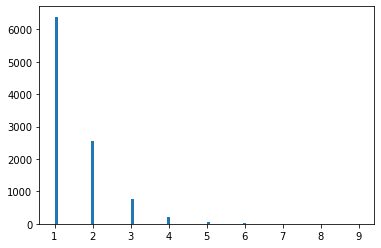

In [170]:
# display the distribution of categories
import matplotlib.pyplot as plt
import numpy as np
# number of categories per paper (histogram)
categories_per_paper = arxiv_dataset.select("categories").collect()
categories_per_paper = [row.categories for row in categories_per_paper]

categories_per_paper = [len(cat.split(" ")) for cat in categories_per_paper]

plt.hist(categories_per_paper, bins=100)
# print also a mean, median, max, std
print("Mean: ", np.mean(categories_per_paper))
print("Median: ", np.median(categories_per_paper))
print("Max: ", np.max(categories_per_paper))
print("Std: ", np.std(categories_per_paper))


#### Most/Least popular category 

In [172]:
# most frequently occuring category
categories = arxiv_dataset.select("categories").collect()
categories = [row.categories for row in categories]
categories = [cat.split(" ") for cat in categories]
categories = [item for sublist in categories for item in sublist]

# most frequently occuring category
print( 
    "Most frequently occuring category: ", 
    max(set(categories), key = categories.count), 
    " (", categories.count(max(set(categories), key = categories.count)), " times)"
)

# least frequently occuring category
print( 
    "Least frequently occuring category: ", 
    min(set(categories), key = categories.count), 
    " (", categories.count(min(set(categories), key = categories.count)), " times)"
)




Most frequently occuring category:  astro-ph  ( 2064  times)
Least frequently occuring category:  astro-ph.SR  ( 1  times)


#### Analyzing the abstracts

(array([  2.,  15.,  17.,  33.,  49.,  52.,  61.,  96.,  83., 115., 102.,
        111., 129., 148., 144., 246., 164., 180., 172., 206., 211., 242.,
        240., 357., 260., 244., 258., 239., 235., 240., 301., 206., 206.,
        225., 194., 197., 182., 166., 227., 150., 150., 143., 152., 133.,
        124., 129., 152., 118., 115.,  97.,  81.,  88.,  89., 104.,  68.,
         74.,  69.,  76.,  60.,  67.,  74.,  76.,  55.,  57.,  53.,  66.,
         49.,  44.,  36.,  59.,  59.,  54.,  48.,  45.,  50.,  36.,  48.,
         37.,  39.,  29.,  34.,  26.,  27.,  21.,  19.,  13.,  15.,   8.,
          6.,  10.,   2.,   6.,   3.,   1.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([  4.  ,   7.13,  10.26,  13.39,  16.52,  19.65,  22.78,  25.91,
         29.04,  32.17,  35.3 ,  38.43,  41.56,  44.69,  47.82,  50.95,
         54.08,  57.21,  60.34,  63.47,  66.6 ,  69.73,  72.86,  75.99,
         79.12,  82.25,  85.38,  88.51,  91.64,  94.77,  97.9 , 101.03,
        104.16, 107.29, 110.42

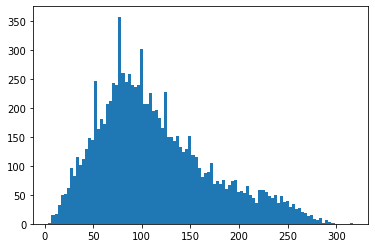

In [178]:
# abstract length (histogram)
abstract_lengths = arxiv_dataset.select("abstract").collect()
abstract_lengths = [row.abstract for row in abstract_lengths]
abstract_lengths = [len(abstract.split(" ")) for abstract in abstract_lengths]
# histogram of abstract lengths
plt.hist(abstract_lengths, bins=100)


In [180]:
# print also a mean, median, max, min, std
print("Mean: ", np.mean(abstract_lengths))
print("Median: ", np.median(abstract_lengths))
print("Max: ", np.max(abstract_lengths))
print("Std: ", np.std(abstract_lengths))
print("Min: ", np.min(abstract_lengths))

Mean:  113.5268
Median:  102.0
Max:  317
Std:  58.02213096534805
Min:  4


### LDA preparations

In [183]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Iustin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Iustin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
# after some research : spacy is a bit faster than nltk on large datasets
def lemmatization(text):
    lemmatizer = nltk.stem.WordNetLemmatizer()
    return " ".join([lemmatizer.lemmatize(word) for word in text.split(" ")])

In [185]:
import spacy
nlp = spacy.load('en_core_web_sm')

In [190]:
@udf(returnType=StringType())
def lemmatization_spacy(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc])

In [187]:
@udf(returnType=StringType())
def remove_stopwords(text):
    doc = nlp(text)
    return " ".join([token.text for token in doc if not token.is_stop])

In [188]:
@udf(returnType=StringType())
def remove_punctuation(text):
    doc = nlp(text)
    return " ".join([token.text for token in doc if not token.is_punct])

In [189]:
@udf(returnType=StringType())
def convert_to_lowercase(text):
    return text.lower()

In [191]:
# apply the function to the abstract column
arxiv_dataset = arxiv_dataset.withColumn("abstract", lemmatization_spacy("abstract"))

In [192]:
# view the first 5 rows
arxiv_dataset.select("abstract").show(5, truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Gensim